In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

# Verified Neural System Identification and Control

This notebook contains some exploratory code, directed towards the problem of 

1. learning the dynamics of a discrete-time dynamical system,
2. learning (simultaneously) a stabilizing controller for the system and a Lyapunov stability certificate, and
3. verifying that the Lyapunov property holds despite some bounded error in system identification

## Theory

Consider a discrete-time dynamical system $x_{t+1} = f(x_t, u_t)$, where $x \in \mathcal{X} \subset \mathbb{R}^n$ and $u \in \mathcal{U} \subset \mathbb{R}^m$, equipped with a feedback controller $u = \pi(x)$. This gives us the closed-loop dynamics $$x_{t+1} = f(x_t, \pi(x_t)) = f_\pi(x_t)$$

Assume the closed-loop system has a fixed point $x^*$ such that $f_\pi(x^*) = x^*$. Let $V(x): \mathbb{R}^n \to \mathbb{R}$. Then the closed loop system will be asymptotically stable at $x^*$ if the following hold:

1. $V(x^*) = 0$
2. $V(x) > 0;\quad \forall x \in (\mathcal{X} - x^*)$
3. $V(x_{t+1}) - V(x_t) < 0;\quad \forall x \in (\mathcal{X} - x^*)$

We can also express (3) in terms of the closed-loop dynamics: $V\circ f_\pi(x_t) - V(x_t) < 0$.

## Approach

We will approach this problem in three steps.

1. First, we will learn the open-loop system dynamics $f(x, u)$ from trajectories, using a neural network with ReLU activations.
2. Next, we will fix the learned dynamics and simultaneously learn a controller $\pi(x)$ and Lyapunov function $V(x)$, using a loss that guides us towards satisfying conditions (1)-(3) above.
3. Finally, we will verify that conditions (2) and (3) hold throughout the domain.

## Step 1: Learn dynamics from data

We'll use a Dubins car model here and try to learn the dynamics (I tried an acrobot model and it was too hard, so I'm starting with this easier model instead).

In [2]:
# Start by building an oracle for the system dynamics. This will be used to generate training trajectories
def f_true(x, u):
    """Dubins car discrete-time dynamics.
    """
    # Define parameters
    dt = 0.1  # timestep
    v = 1     # forward speed of the car
    
    # Unpack state variables
    assert x.shape == (3, 1)  # x, y, theta
    assert u.shape == (1, 1)
    
    # Construct the derivatives
    xdot = np.zeros(x.shape)
    # First derivatives of x, y, and theta
    xdot[0, 0] = v*np.cos(x[2, 0])
    xdot[1, 0] = v*np.sin(x[2, 0])
    xdot[2, 0] = u[0, 0]
    
    # Apply a simple euler integration to advance the dynamics
    new_x = np.copy(x)
    new_x += xdot * dt
    
    return new_x


In [3]:
# Gather training and test data by sampling directly from the joint state/action space
# We'll use the test data to characterize the error in the learned dynamics.
N_train = 1000000
N_test = 200000

x_min = np.zeros((3, 1))
x_min[0, 0] = -10
x_min[1, 0] = -10
x_min[2, 0] = -np.pi
x_max = -1 * x_min
u_max = np.array([[20]])
u_min = -u_max

sample_min = np.concatenate((x_min, u_min))
sample_max = np.concatenate((x_max, u_max))

x_train = np.random.uniform(sample_min, sample_max, (4, N_train)).transpose()
x_test = np.random.uniform(sample_min, sample_max, (4, N_test)).transpose()

f_train = np.zeros((N_train, 3))
for i, x in enumerate(x_train):
    f_train[i, :] = f_true(x[:3].reshape(3, 1), x[-1].reshape(1, 1)).reshape(3,)
f_test = np.zeros((N_test, 3))
for i, x in enumerate(x_test):
    f_test[i, :] = f_true(x[:3].reshape(3, 1), x[-1].reshape(1, 1)).reshape(3,)

In [4]:
# Convert trajectories to torch tensors
x_train_torch = torch.from_numpy(x_train).float()
x_test_torch = torch.from_numpy(x_test).float()
f_train_torch = torch.from_numpy(f_train).float()
f_test_torch = torch.from_numpy(f_test).float()

In [5]:
# Define hyperparameters for the learning process
learning_rate = 5e-4
batch_size = 1024
max_epochs = 1000

n_dims = 3
n_controls = 1

# Optionally load a model instead of training a new one
use_saved_model = True
if use_saved_model:
    filename = 'logs/small_dubins_model_best.pth.tar'
    loaded_data = torch.load(filename)

# Define the network for learning the dynamics
if use_saved_model:
    n_hidden_layers = loaded_data['n_hidden_layers']
    hidden_layer_size = loaded_data['neurons_per_layer']
else:
    n_hidden_layers = 1
    hidden_layer_size = 32

layers = []
# Input layer: inputs are states and controls, outputs are hidden layer activations
input_layer = [nn.Linear(n_dims + n_controls, hidden_layer_size), nn.ReLU()]
layers = layers + input_layer
# Hidden layers: inputs and outputs are the same size
for i in range(n_hidden_layers - 1):
    hidden_layer = [nn.Linear(hidden_layer_size, hidden_layer_size), nn.ReLU()]
    layers = layers + hidden_layer
# Output layer: outputs new states
layers = layers + [nn.Linear(hidden_layer_size, n_dims)]

# Build the network from these components
dynamics_model = nn.Sequential(*layers)
if use_saved_model:
    dynamics_model.load_state_dict(loaded_data['dynamics_model'])
    dynamics_model.eval()

# Train the dynamics model (if we haven't already loaded one)

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = learning_rate * (0.1 ** (epoch // 50))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Define the loss function
loss_fn = nn.L1Loss()

# Train the network
optimizer = optim.Adam(dynamics_model.parameters(), lr=learning_rate)

# Also log histories of training and test loss
training_losses = []
test_losses = []
best_loss = np.inf

# Skip training if we've already loaded a model
if use_saved_model:
    max_epochs = 0
    epoch = 0

epochs = tqdm(range(max_epochs))
for epoch in epochs:
    # Set the adaptive learning rate
    adjust_learning_rate(optimizer, epoch)

    # Randomize the presentation order in each epoch
    permutation = torch.randperm(N_train)

    loss_acumulated = 0.0
    for i in range(0, N_train, batch_size):
        # Get input/output pairs
        indices = permutation[i:i+batch_size]
        state_control_pairs = x_train_torch[indices]
        next_state = f_train_torch[indices]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        predicted_next_state = dynamics_model(state_control_pairs)

        # Compute loss and backpropagate
        loss = loss_fn(predicted_next_state, next_state)
        loss += torch.max(torch.norm(predicted_next_state - next_state, dim=1))
        loss_acumulated += loss.item()
        loss.backward()

        # Update the parameters
        optimizer.step()

    # save progress
    training_losses.append(loss_acumulated / (N_train / batch_size))

    # Reset accumulated loss and get loss for the test set
    loss_acumulated = 0.0
    with torch.no_grad():
        # Get input/output pairs
        state_control_pairs = x_test_torch
        next_state = f_test_torch

        predicted_next_state = dynamics_model(state_control_pairs)

        loss = loss_fn(predicted_next_state, next_state)
        loss += torch.max(torch.norm(predicted_next_state - next_state, dim=1))
        test_losses.append(loss)
        epochs.set_description(f"Test loss: {round(loss.item(), 4)}")

        if loss <= best_loss:
            best_loss = loss
            filename = 'logs/small_dubins_model_best.pth.tar'
            torch.save({'n_hidden_layers':n_hidden_layers,
                        'neurons_per_layer':hidden_layer_size,
                        'dynamics_model': dynamics_model.state_dict(),
                        'training_losses': training_losses,
                        'test_losses': test_losses}, filename)

In [6]:
# Plot the loss curves
plt.figure()
plt.plot(range(max_epochs), training_losses)
plt.plot(range(max_epochs), test_losses)
plt.gca().set_xticks(np.arange(0, epoch+1, 100))
plt.xlabel("Epoch")
plt.ylabel("Regression Loss (Mean abs + max)")
plt.legend(["Training", "Test"])
plt.yscale("log")

<IPython.core.display.Javascript object>

In [7]:
loss_acumulated = 0.0
with torch.no_grad():
    # Get input/output pairs
    state_control_pairs = x_test_torch
    next_state = f_test_torch

    predicted_next_state = dynamics_model(state_control_pairs)

    loss = loss_fn(predicted_next_state, next_state)
    print(f"Test loss (mean L1): {round(loss.item(), 4)}")
    loss = torch.max(torch.norm(predicted_next_state - next_state, dim=1))
    print(f"Test loss (max L2): {round(loss.item(), 4)}")

Test loss (mean L1): 0.0093
Test loss (max L2): 0.0311


## Step 2: Learn a controller to stabilize and provide forward set invariance

Now that we've learned the dynamics, we can design a controller using those dynamics. Our goals for this controller are to:

1. Reach a goal (stabilize to a 1 m x 1 m box)
2. Avoid obstacles (other boxes)

First, we need to define the environment. Let's start with something relatively simple: two boxes to avoid (orange) and one box to reach (green). All boxes have dimensions 1x1.

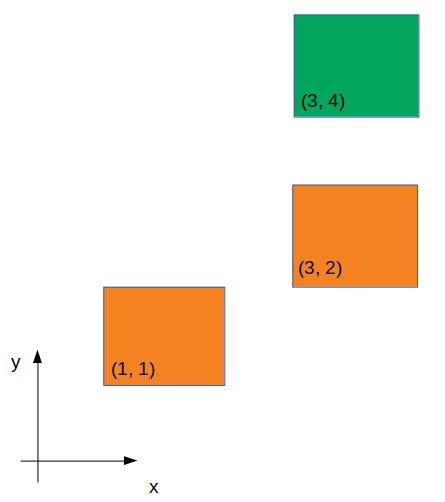

In [18]:
# We can define the boxes as polytopes (linear inequalities on x and y)
def check_unsafe(xytheta_tensor):
    """Takes a tensor of size N x 3, and returns an N x 1 tensor of booleans that are true
    if the corresponding point (x, y, theta) is in an unsafe region"""
    N = xytheta_tensor.shape[0]
    
    # The first obstacle has 1 <= x <= 2 and 1 <= y <= 2
    obstacle1_mask = torch.ones((N,), dtype=torch.bool)
    torch.logical_and(obstacle1_mask, xytheta_tensor[:, 0] >= 1, out=obstacle1_mask)
    torch.logical_and(obstacle1_mask, xytheta_tensor[:, 0] <= 2, out=obstacle1_mask)
    torch.logical_and(obstacle1_mask, xytheta_tensor[:, 1] >= 1, out=obstacle1_mask)
    torch.logical_and(obstacle1_mask, xytheta_tensor[:, 1] <= 2, out=obstacle1_mask)
    
    # The second obstacle has 3 <= x <= 4 and 2 <= y <= 3
    obstacle2_mask = torch.ones((N,), dtype=torch.bool)
    torch.logical_and(obstacle2_mask, xytheta_tensor[:, 0] >= 3, out=obstacle2_mask)
    torch.logical_and(obstacle2_mask, xytheta_tensor[:, 0] <= 4, out=obstacle2_mask)
    torch.logical_and(obstacle2_mask, xytheta_tensor[:, 1] >= 2, out=obstacle2_mask)
    torch.logical_and(obstacle2_mask, xytheta_tensor[:, 1] <= 3, out=obstacle2_mask)
    
    return torch.logical_or(obstacle1_mask, obstacle2_mask)


def get_unsafe_violation(xytheta_tensor, margin=0.1):
    """Takes a tensor of size N x 3 and returns a N x 1 tensor of floats indicating the amount of violation
    of the unsafe region (>0 for a point inside an unsafe region, 0 for a point outside the unsafe region).
    For robustness, we inflate each obstacle by a constant margin"""
    # The unsafe regions are defined by four inequalities each. The violation is the minimum slack of
    # any satisfied inequality
    N = xytheta_tensor.shape[0]
    violations = torch.zeros((N, 1))
    
    # First figure out which points are inside each obstacle
    # The first obstacle has 1 <= x <= 2 and 1 <= y <= 2
    obstacle1_mask = torch.ones((N,), dtype=torch.bool)
    torch.logical_and(obstacle1_mask, xytheta_tensor[:, 0] >= 1-margin, out=obstacle1_mask)
    torch.logical_and(obstacle1_mask, xytheta_tensor[:, 0] <= 2+margin, out=obstacle1_mask)
    torch.logical_and(obstacle1_mask, xytheta_tensor[:, 1] >= 1-margin, out=obstacle1_mask)
    torch.logical_and(obstacle1_mask, xytheta_tensor[:, 1] <= 2+margin, out=obstacle1_mask)
    
    # The second obstacle has 3 <= x <= 4 and 2 <= y <= 3
    obstacle2_mask = torch.ones((N,), dtype=torch.bool)
    torch.logical_and(obstacle2_mask, xytheta_tensor[:, 0] >= 3-margin, out=obstacle2_mask)
    torch.logical_and(obstacle2_mask, xytheta_tensor[:, 0] <= 4+margin, out=obstacle2_mask)
    torch.logical_and(obstacle2_mask, xytheta_tensor[:, 1] >= 2-margin, out=obstacle2_mask)
    torch.logical_and(obstacle2_mask, xytheta_tensor[:, 1] <= 3+margin, out=obstacle2_mask)
    
    # Next, for the points inside each obstacle, get the minimum violation
    # Obstacle 1 first
    if obstacle1_mask.any():
        inside_obstacle_1 = xytheta_tensor[obstacle1_mask, :]
        obs_1_violation_1 = inside_obstacle_1[:, 0] - (1 - margin)
        obs_1_violation_2 = 2 + margin - inside_obstacle_1[:, 0]
        obs_1_violation_3 = inside_obstacle_1[:, 1] - (1 - margin)
        obs_1_violation_4 = 2 + margin - inside_obstacle_1[:, 1]
        obs_1_violation = torch.hstack((obs_1_violation_1, obs_1_violation_2, obs_1_violation_3, obs_1_violation_4))
        obs_1_violation, _ = torch.min(obs_1_violation, -1)
        violations[obstacle1_mask, :] += obs_1_violation
    
    # Obstacle 2 next
    if obstacle2_mask.any():
        inside_obstacle_2 = xytheta_tensor[obstacle2_mask, :]
        obs_2_violation_1 = inside_obstacle_2[:, 0] - (3 - margin)
        obs_2_violation_2 = 4 + margin - inside_obstacle_2[:, 0]
        obs_2_violation_3 = inside_obstacle_2[:, 1] - (2 - margin)
        obs_2_violation_4 = 3 + margin - inside_obstacle_2[:, 1]
        obs_2_violation = torch.hstack((obs_2_violation_1, obs_2_violation_2, obs_2_violation_3, obs_2_violation_4))
        obs_2_violation, _ = torch.min(obs_2_violation, -1)
        violations[obstacle2_mask, :] += obs_2_violation
    
    return violations
    

# Define the center of the goal region (for calculating a Lyapunov function later)
goal_center = torch.tensor([3.5, 4.5, 0.0]).reshape((3, 1))


def check_goal(xytheta_tensor):
    """Takes a tensor of size N x 3, and returns an N x 1 tensor of booleans that are true
    if the corresponding point (x, y, theta) is in the goal region"""
    N = xytheta_tensor.shape[0]
    
    # The goal has 2 <= x <= 3 and 4 <= y <= 5
    goal_mask = torch.ones((N,), dtype=torch.bool)
    torch.logical_and(goal_mask, xytheta_tensor[:, 0] >= 3, out=goal_mask)
    torch.logical_and(goal_mask, xytheta_tensor[:, 0] <= 4, out=goal_mask)
    torch.logical_and(goal_mask, xytheta_tensor[:, 1] >= 4, out=goal_mask)
    torch.logical_and(goal_mask, xytheta_tensor[:, 1] <= 5, out=goal_mask)
    
    return goal_mask

In [9]:
# Now we can gather training and test points
# (basically samples from the state space, segmented into safe an unsafe regions)
N_train = 1000000
N_test = 200000

x_min = np.zeros((3, 1))
x_min[0, 0] = -1
x_min[1, 0] = -1
x_min[2, 0] = -np.pi
x_max = -1 * x_min
x_max[0, 0] = 7
x_max[1, 0] = 7

# Sample training points
x_train = torch.from_numpy(np.random.uniform(x_min, x_max, (3, N_train)).transpose()).float()
# Segment into unsafe, safe, and goal points
unsafe_mask_train = check_unsafe(x_train)
goal_mask_train = check_goal(x_train)
safe_mask_train = torch.logical_and(torch.logical_not(unsafe_mask_train), torch.logical_not(goal_mask_train))
x_unsafe_train = x_train[unsafe_mask_train, :]
x_safe_train = x_train[safe_mask_train, :]
x_goal_train = x_train[goal_mask_train, :]

# Sample test points
x_test = torch.from_numpy(np.random.uniform(x_min, x_max, (3, N_test)).transpose()).float()
# Segment into unsafe, safe, and goal points
unsafe_mask_test = check_unsafe(x_test)
goal_mask_test = check_goal(x_test)
safe_mask_test = torch.logical_and(torch.logical_not(unsafe_mask_test), torch.logical_not(goal_mask_test))
x_unsafe_test = x_test[unsafe_mask_test]
x_safe_test = x_test[safe_mask_test, :]
x_goal_test = x_test[goal_mask_test]

<IPython.core.display.Javascript object>


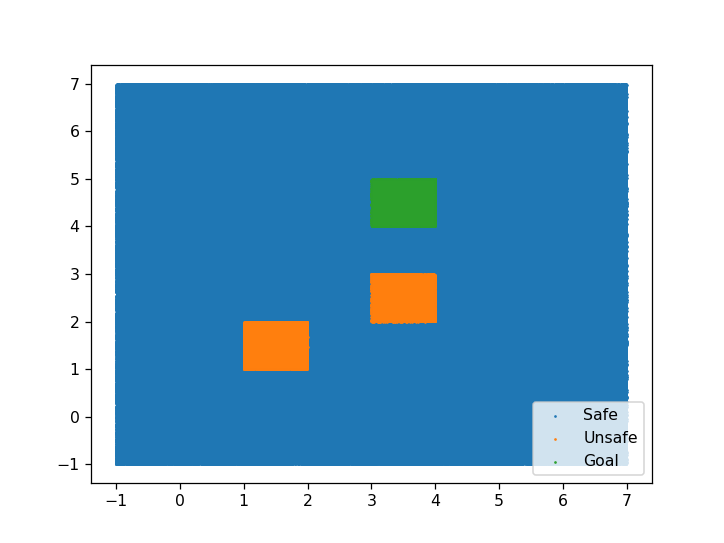

In [46]:
plt.figure()
plt.scatter(x_safe_train[:, 0], x_safe_train[:, 1], 0.5)
plt.scatter(x_unsafe_train[:, 0], x_unsafe_train[:, 1], 0.5)
plt.scatter(x_goal_train[:, 0], x_goal_train[:, 1], 0.5)
plt.legend(["Safe", "Unsafe", "Goal"], loc='lower right')

In [96]:
# Now we have to define the controller and Lyapunov networks. For ease of composition later on,
# we'll define these as two different classes of network

class ControllerReLUNet(nn.Module):
    """A class to represent a controller for a dynamical system, using ReLU activations"""

    def __init__(self, n_dims, n_controls):
        super(ControllerReLUNet, self).__init__()
        
        # Define the layers for the network
        self.hidden_layer_size = 8
        self.input_layer = nn.Linear(n_dims, hidden_layer_size)
        self.hidden_layer_1 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.output_layer = nn.Linear(hidden_layer_size, n_controls)
        
        # Instantiate the activation function
        self.activation = nn.ReLU()
        
    def forward(self, x):
        """Compute the control input for state x"""
        input_layer_activations = self.activation(self.input_layer(x))
        hidden_layer_1_activations = self.activation(self.hidden_layer_1(input_layer_activations))
        output_layer_activations = self.activation(self.output_layer(hidden_layer_1_activations))
        
        return output_layer_activations


class LyapunovReLUNet(nn.Module):
    """A class to represent a lyapunov function for a dynamical system, using a max of affine functions"""

    def __init__(self, n_dims):
        super(LyapunovReLUNet, self).__init__()
        
        # This is kind of a peculiar network structure. We want the Lyapunov function to be convex,
        # so we construct it as a max of a bunch of affine functions
        self.num_affine_units = 64
        self.affine_layer = nn.Linear(n_dims, self.num_affine_units)
        
    def forward(self, x):
        """Compute the control input for state x"""
        # Compute the value of each affine function (if x is bs x 3, then this should be bs x num_affine_units)
        affine_unit_values = self.affine_layer(x)
        
        # Add a zero unit
        zeros = torch.zeros((affine_unit_values.shape[0], 1))
        affine_unit_values = torch.cat([affine_unit_values, zeros], dim=1)
        
        # Take a maximum of the affine functions
        # This should be bs x 1
        output, _ = torch.max(affine_unit_values, dim=-1)
        return output


In [86]:
# We also want to define some custom loss functions.
def control_loss(u, max_control=0):
    """Encourage low-norm control inputs"""
    relu = nn.ReLU()
    return relu(torch.square(u) - max_control**2).mean()


def forward_set_invariance_loss(x_safe, controller, dynamics_model, margin=0.0):
    """Penalize any control input which causes the system to leave the safe region
    
    More particularly, for all pairs (x, u) in the safe set, if f(x, u) is in the unsafe set, returns the
    mean + max violation, where the violation is the distance by which f(x, u) infringes on the unsafe set.
    To encourage robustness, the violation actually starts increasing from zero at some margin from the boundary
    of the unsafe set.
    
    args:
        x_safe - Nx3 tensor of points in the safe region
        u - Nx1 tensor of control inputs for each point
        dynamics_model - a NN that takes [x, y, theta, u]_t and returns [x, y, theta]_{t+1}
        margin - the amount of margin to apply to the unsafe set.
    """
    # Get predicted next state
    u = controller(x_safe)
    inputs = torch.hstack((x_safe, u))
    x_next = dynamics_model(inputs)
    
    # And get one state after that
    u = controller(x_next)
    inputs = torch.hstack((x_next, u))
    x_next2 = dynamics_model(inputs)
    
    # Find all points that have left the safe state
    violations = get_unsafe_violation(x_next2, margin)
    
    # Return the total violation
    return violations.sum()


def lyapunov_loss(x_goal, x_safe, u, dynamics_model, lyapunov_model):
    """Penalize any portion of the safe state space where the Lyapunov function does not satisfy
    the Lyapunov conditions.
    
    args:
        x_goal - N_goal x 3 tensor of points in the goal region
        x_safe - N_safe x 3 tensor of points in the safe region
        u - Nx1 tensor of control inputs for each point
        dynamics_model - a NN that takes [x, y, theta, u]_t and returns [x, y, theta]_{t+1}
        lyapunov_model - a NN that takes [x, y, theta] and returns V
    """
    # There are three conditions on the Lyapunov function V(x).
    #   1.) V(x) = 0 in the goal region
    #   2.) V(x) is convex
    #   3.) V(x_{t+1}) - V(x_t) <= -lambda * alpha(||x||)
    #       V(x_{t+1}) - V(x_t) + lambda * alpha(||x||) <= 0
    #       ReLU(V(x_{t+1}) - V(x_t) + lambda * alpha(||x||)) = 0
    #   4.) a1 ||x|| <= V(x) <= a2 ||x||
    #
    # (where alpha is a class-K extended function)
    #
    # (2) is satisfied by construction, and we add a loss term for the other three

    loss = 0.0
    
    # Add a term to encourage (1)
    loss += torch.sum(lyapunov_model(x_goal) ** 2)
    
    # Add a term to encourage (3)
    inputs = torch.hstack((x_safe, u))
    x_next = dynamics_model(inputs)
    V_now = lyapunov_model(x_safe)
    V_next = lyapunov_model(x_next)
    relu = nn.ReLU()
    lambda_lyap = 0.0
    goal_diff = x_safe - goal_center[:, None]
    loss += relu(V_next - V_now + lambda_lyap * torch.linalg.norm(goal_diff, dim=-1)).mean()
    
    # Add terms to encourage (4)
#     loss += relu(V_now - 10*torch.linalg.norm(goal_diff, dim=-1)).mean()
#     loss += relu(0.01*torch.linalg.norm(goal_diff, dim=-1) - V_now).mean()
    
    return loss

Now that we've defined all the needed networks and loss functions, we can start training!

In [ ]:
# Define hyperparameters for the learning process
learning_rate = 1e-3
batch_size = 1024
max_epochs = 500

# For robustness, we apply a margin to the unsafe set during training (but not during test)
safety_margin = 0.1

# Define the network for learning the dynamics
controller = ControllerReLUNet(n_dims, n_controls)
lyap_function = LyapunovReLUNet(n_dims)


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = learning_rate * (0.5 ** (epoch // 10))
    lr = max(1e-5, lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the networks
optimizer = optim.Adam(list(controller.parameters()) + list(lyap_function.parameters()), lr=learning_rate)

# Also log histories of training and test loss
training_losses = []
test_losses = []
test_lyap_losses = []
test_set_invariance_losses = []
best_loss = np.inf

epochs = tqdm(range(max_epochs))
for epoch in epochs:
    # Set the adaptive learning rate
    adjust_learning_rate(optimizer, epoch)

    # Randomize the presentation order in each epoch
    permutation = torch.randperm(N_train)

    loss_acumulated = 0.0
    for i in range(0, N_train, batch_size):
        # Get samples from the state space and segment them as safe/unsafe/goal
        indices = permutation[i:i+batch_size]
        x = x_train[indices]
        unsafe_mask = check_unsafe(x)
        goal_mask = check_goal(x)
        safe_mask = torch.logical_and(torch.logical_not(unsafe_mask), torch.logical_not(goal_mask))
        x_safe = x[safe_mask, :]
        x_unsafe = x[unsafe_mask, :]
        x_goal = x[goal_mask, :]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass to get the controller output (the forward pass for the lyapunov function
        # happens inside the lyapunov loss function)
        u_safe = controller(x_safe)
        u_unsafe = controller(x_unsafe)
        u_goal = controller(x_goal)

        # Compute loss and backpropagate
        loss = 0.0
        loss += control_loss(torch.vstack((u_safe, u_goal)))
        loss += forward_set_invariance_loss(x_unsafe, controller, dynamics_model, safety_margin)
        loss += forward_set_invariance_loss(x_safe, controller, dynamics_model, safety_margin)
        loss += lyapunov_loss(x_goal, x_safe, u_safe, dynamics_model, lyap_function)
        loss.backward()
        
        loss_acumulated += loss

        # Update the parameters
        optimizer.step()

    # save progress
    training_losses.append(loss_acumulated / (N_train / batch_size))

    # Reset accumulated loss and get loss for the test set
    loss_acumulated = 0.0
    with torch.no_grad():
        # Use samples from the state space segmented as safe/unsafe/goal to compute test loss
        u_safe = controller(x_safe_test)
        u_goal = controller(x_goal_test)

        # Compute loss and backpropagate
        loss = 0.0
        loss += control_loss(torch.vstack((u_safe, u_goal)))
        set_invariance_loss = forward_set_invariance_loss(x_safe_test, controller, dynamics_model, safety_margin)
        loss += set_invariance_loss
        lyap_loss = lyapunov_loss(x_goal_test, x_safe_test, u_safe, dynamics_model, lyap_function)
        loss += lyap_loss

        epochs.set_description(f"Test loss: {round(loss.item(), 4)}")
        test_losses.append(loss)
        test_set_invariance_losses.append(set_invariance_loss)
        test_lyap_losses.append(lyap_loss)

        if loss <= best_loss:
            best_loss = loss
            filename = 'logs/combined_dubins_controller_lyap_dynamics.pth.tar'
            torch.save({'dynamics_model': dynamics_model.state_dict(),
                        'controller': controller.state_dict(),
                        'lyap_function': lyap_function.state_dict(),
                        'training_losses': training_losses,
                        'test_losses': test_losses}, filename)

<IPython.core.display.Javascript object>


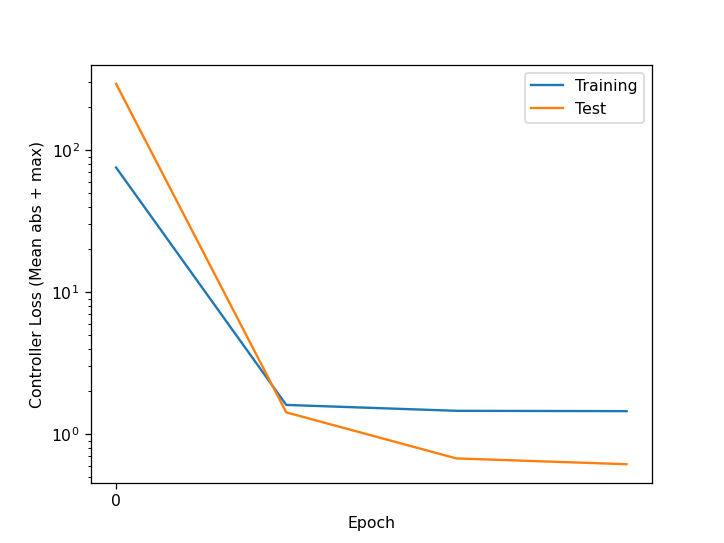

In [113]:
# Plot the total loss curves
plt.figure()
plt.plot(range(epoch), training_losses)
plt.plot(range(epoch), test_losses)
plt.gca().set_xticks(np.arange(0, epoch+1, 100))
plt.xlabel("Epoch")
plt.ylabel("Controller Loss (Mean abs + max)")
plt.legend(["Training", "Test"])
plt.yscale("log")

<IPython.core.display.Javascript object>


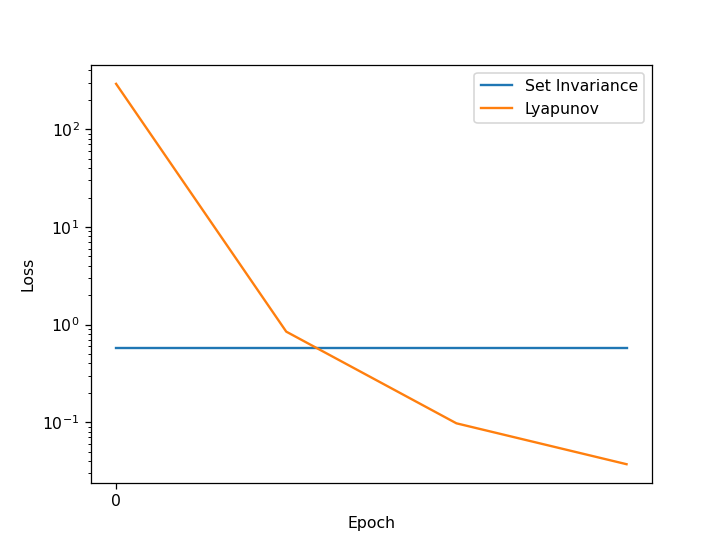

In [114]:
# Plot the loss curves for lyapunov and set invariance loss on the test set
plt.figure()
plt.plot(range(epoch), test_set_invariance_losses)
plt.plot(range(epoch), test_lyap_losses)
plt.gca().set_xticks(np.arange(0, epoch+1, 100))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Set Invariance", "Lyapunov"])
plt.yscale("log")

<IPython.core.display.Javascript object>


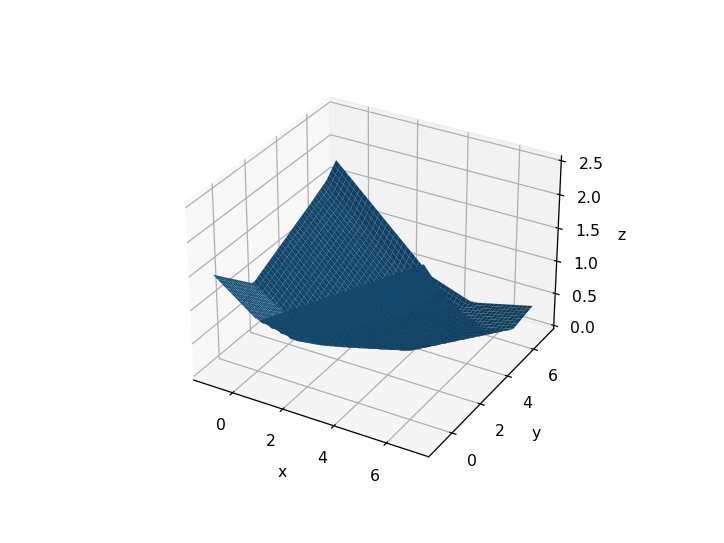

<IPython.core.display.Javascript object>


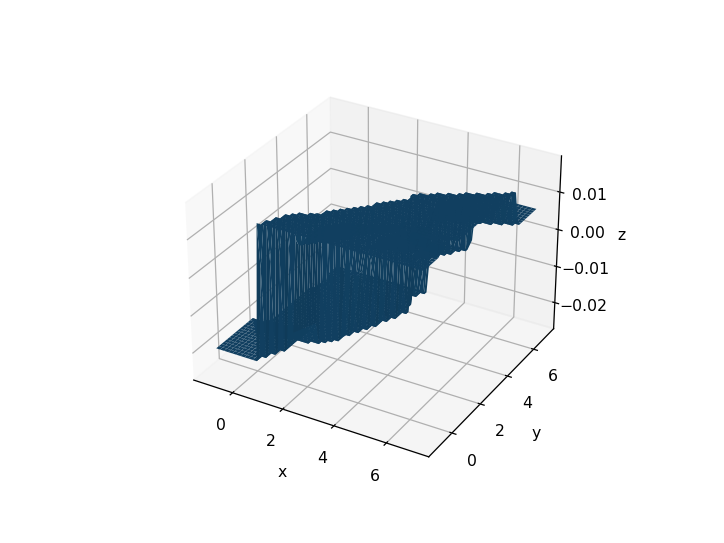

In [115]:
# Plot the Lyapunov function
with torch.no_grad():
    n_pts = 50
    x = torch.linspace(-1, 7, n_pts)
    y = torch.linspace(-1, 7, n_pts)
    grid_x, grid_y = torch.meshgrid(x, y)
    V_values = torch.zeros(n_pts, n_pts)
    V_delta_values = torch.zeros(n_pts, n_pts)
    for i in range(n_pts):
        for j in range(n_pts):
            state = torch.tensor([[x[i], y[j], 0]])
            V_values[i, j] = lyap_function(state)
            u = controller(state)
            next_state = dynamics_model(torch.hstack((state, u)))
            V_next = lyap_function(next_state)
            V_delta_values[i, j] = V_next - V_values[i, j]
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(grid_x, grid_y, V_values.numpy())
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(grid_x, grid_y, V_delta_values.numpy())
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

<IPython.core.display.Javascript object>


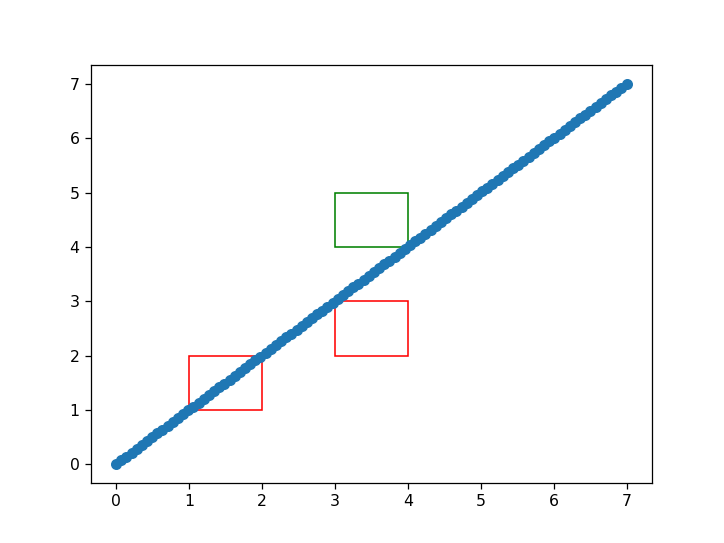

<IPython.core.display.Javascript object>


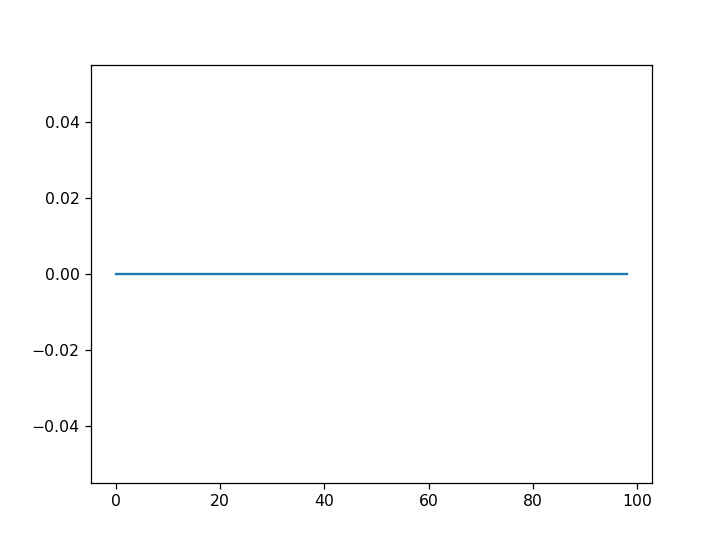

<IPython.core.display.Javascript object>


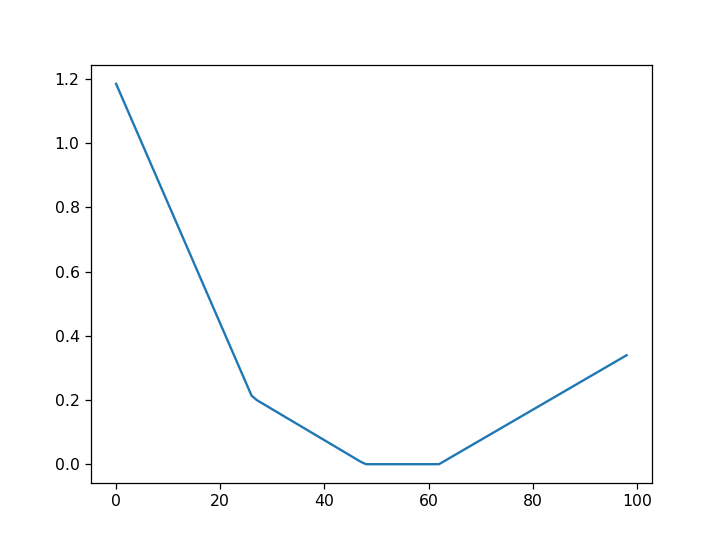

In [117]:
# Simulate a trajectory! From the origin
T = 100
trajectory = torch.zeros((T, 3))
trajectory[0, 2] = np.pi/4
controls = torch.zeros((T-1,))
Vs = torch.zeros((T-1,))

with torch.no_grad():
    for t in range(0, T-1):
        x_now = trajectory[t, :].reshape((1, 3))
        u = controller(x_now)
        x_next = torch.from_numpy(f_true(x_now.reshape((3, 1)), u))
        trajectory[t+1, :] = x_next.reshape((3,))
        controls[t] = u
        Vs[t] = lyap_function(x_now)

    # Plot the trajectory
    plt.figure()
    ax = plt.gca()
    ax.plot(trajectory[:, 0], trajectory[:, 1], '-o')
    obs1 = patches.Rectangle((1,1),1,1,linewidth=1,edgecolor='r',facecolor='none')
    obs2 = patches.Rectangle((3,2),1,1,linewidth=1,edgecolor='r',facecolor='none')
    goal = patches.Rectangle((3,4),1,1,linewidth=1,edgecolor='g',facecolor='none')
    ax.add_patch(obs1)
    ax.add_patch(obs2)
    ax.add_patch(goal)
    
    plt.figure()
    plt.plot(range(T-1), controls)
    plt.figure()
    plt.plot(range(T-1), Vs)